# Zonnepaneelefficiëntie
**Student:** Tristan Gerritsen \
**Studentnummer:** S1158446

## 1. Business Understanding
We kijken naar zonnepaneeldata over een periode van net iets minder naar twee jaar. De metingen bestaan uit het wattage dat elke minuut door de panelen werd opgewekt. Hierbij is de data al omgezet naar watt per vierkante meter.

We zijn op zoek naar de efficientie van de panelen. Deze kan berekend worden door de theoretische hoeveelheid opbrengst te nemen en deze te verlagen met een bepaalde factor om de werkelijke meting te benaderen. Deze factor is de efficientie.

Om deze berekening te moeten doen, maken we gebruik van de pvlib library. Hierbij is het nodig om de helling van het zonnepaneel met het dak te weten (de tilt). En ook de richting van het paneel (de azimuth). De azimuth loopt van 0 graden noord, naar 90 graden oost, naar 180 graden zuid en dan naar 270 graden west.

## 2. Data Understanding

### 2.1. Bibliotheken importeren
Om de data te kunnen uitlezen en tonen, maak ik gebruik van de volgende bibliotheken en functies daarin. Ook importeer ik alvast `scipy` voor later.

In [4]:
# Imports
import pandas as pd
import seaborn as sns
import historicdutchweather
import pytz
from typing import Tuple
import pvlib
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### 2.2. Dataset inladen
Aangeleverd is een dataset, waarin we zien dat het bestaat uit een bepaald tijdopname (die ik omzet naar de juiste _pandas datetime_), samen met een lezing van het wattage dat op dat moment geproduceerd werd.

In [5]:
df = pd.read_csv('dataset.csv')
df['time'] = pd.to_datetime(df['time'])

In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266008 entries, 0 to 1266007
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   time        1266008 non-null  datetime64[ns, UTC]
 1   production  1266008 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 19.3 MB


,time,production
0,2020-04-10 10:31:35+00:00,96.666667
1,2020-04-10 10:32:35+00:00,96.666667
2,2020-04-10 10:33:35+00:00,93.333333
3,2020-04-10 10:34:35+00:00,100.000000
4,2020-04-10 10:35:36+00:00,103.333333


### 2.3. Production
Zoals we hierboven gezien hebben, bestaat de `production`-waarde uit een decimaal getal, waarin uit de business understanding blijkt dat dit getal getrokken is over wattage per vierkante meter (d.i. $W / m^{2}$). Ook kunnen we zien dat het geen absolute waarde is – rij 2 heeft immers minder productie dan rij 1 en 3 – hier hoeven we dus niet het verschil ($\Delta$) van te nemen.

Door de min, max en gemiddelde-waarden te nemen uit de lijst, zien we dat het wel eens kan voorkomen dat er niets wordt opgeleverd – verklaarbaar bijvoorbeeld als het een bewolkte nacht is. Daarnaast zien we dat we weleens een productie van $2206 \frac{2}{3} W / m^{2}$ opleveren; een getal dat gigantisch groter is dan het gemiddelde van $\pm 22 W/m^{2}$.

In [17]:
production = df["production"]
print("Min:", production.min())
print("Max:", production.max())
print("Mean:", production.mean())
production

Min: 0.0
Max: 2206.6666666666665
Mean: 21.81287427356964


0           96.666667
1           96.666667
2           93.333333
3          100.000000
4          103.333333
              ...    
1266003      0.000000
1266004      3.333333
1266005      0.000000
1266006      0.000000
1266007      3.333333
Name: production, Length: 1266008, dtype: float64

### 2.4. Tijdspannes
Ook zou elke minuut een opname gedaan moeten zijn, maar rij 4 toont al een afwijking in een seconde. Om de mate van afwijking per datapunt te bepalen, bekijk ik de gemiddelde $\Delta T$ per meting. Hier blijkt dat er een verschil optrad van 1 seconde, maar ook eentje van 1 minuut en 1 seconde.

In [14]:
deltas = df["time"].diff().shift(-1)
print("Min:", deltas.min())
print("Max:", deltas.max())
print("Mean:", deltas.mean())

Min: 0 days 00:00:01
Max: 0 days 01:01:00
Mean: 0 days 00:01:00.008435972


Omdat er toch wel een flink verschil zit in de metingen, bekijk ik hoe vaak zo'n afwijking nou voorkomt. Daaruit blijkt dat maar $\pm 80 \%$ van de momenten "juist" is. Een interpolatie is dus vereist om een eerlijke uitspraak te kunnen doen over deze data.

In [13]:
print("Juiste waardes:", deltas[deltas == pd.Timedelta("1min")].count() / deltas.count() * 100, "%")

Juiste waardes: 79.75840575920986 %


### 2.5. Weerdataset ophalen
Om een relationele uitspraak te doen over de zonnepaneeldata jegens het weerbericht, gebruik ik historische gegevens van KNMI. Deze heb ik eerder opgehaald met de [`historicdutchweather`](https://pypi.org/project/historicdutchweather/)-bibliotheek en gestopt in een `weather.csv`-bestand, zodat bij iteratief werken, ik niet afhankelijk hoef te zijn van de KNMI-website.

In [20]:
# Maak gebruik van de historicdutchweather.get_local_weather functie of importeer rechtstreeks de data vanaf de KNMI site
df_weather = pd.read_csv('weather.csv')
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21096 entries, 0 to 21095
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  21096 non-null  object 
 1   T           21096 non-null  float64
 2   FH          21096 non-null  float64
 3   DD          20990 non-null  float64
 4   Q           21096 non-null  float64
 5   DR          21096 non-null  float64
 6   RH          21096 non-null  float64
 7   U           21096 non-null  float64
 8   N           21025 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


,Unnamed: 0,T,FH,DD,Q,DR,RH,U,N
0,2020-04-10 00:00:00+00:00,4.461015,2.604330,56.449253,-1.482197e-323,-1.482197e-323,-1.482197e-323,85.211640,1.947349
1,2020-04-10 01:00:00+00:00,4.014926,2.604330,58.753726,-1.482197e-323,-1.482197e-323,-1.482197e-323,89.105820,7.088386
2,2020-04-10 02:00:00+00:00,3.437970,2.249255,62.304473,-1.482197e-323,-1.482197e-323,-1.482197e-323,91.230447,8.000000
3,2020-04-10 03:00:00+00:00,3.019567,2.124627,54.608945,-1.482197e-323,-1.482197e-323,-1.482197e-323,92.124627,8.000000
4,2020-04-10 04:00:00+00:00,3.175657,2.355075,60.000000,6.449253e-01,-1.482197e-323,-1.482197e-323,92.355075,8.000000


Hier zien we een hoop gegevens, maar nog niet echt nuttige informatie. Daarom 

## Data Preparation

In [ ]:
df_production = df
df_production['time'] = pd.to_datetime(df_production['time'])
df_production = df_production.set_index('time')
df_production

Omdat de kolomsymbolen in beginsel niet vanzelfsprekend zijn, hernoem ik deze naar een canonieke omschrijving. De overbodige kolommen verberg ik, zodat deze niet afleidend zijn voor de proef.

In [ ]:
df_weather = df_weather.rename(columns={"Unnamed: 0": "time", "N": "weer"})
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather = df_weather.set_index('time')

df_weather = df_weather.drop(['T', 'FH', 'DD', 'Q', 'DR', 'RH', 'U'], axis=1)

df_weather.info()
df_weather.head()

## Resampling naar xx minuten

In [18]:
# Resample je data naar 5 of 10 minuten
#df_production = df.resample('5min')

# df_weather_resampled = df_weather.resample('10min').mean()
df_weather_resampled = df_weather

df_production_resampled = df_production.resample('10min').median()

print(df_weather_resampled)

                               weer
time                               
2020-04-10 00:00:00+00:00  1.947349
2020-04-10 01:00:00+00:00  7.088386
2020-04-10 02:00:00+00:00  8.000000
2020-04-10 03:00:00+00:00  8.000000
2020-04-10 04:00:00+00:00  8.000000
...                             ...
2022-09-05 19:00:00+00:00  7.087373
2022-09-05 20:00:00+00:00  8.000000
2022-09-05 21:00:00+00:00  8.000000
2022-09-05 22:00:00+00:00  8.000000
2022-09-05 23:00:00+00:00  8.000000

[21096 rows x 1 columns]


<Axes: xlabel='time'>

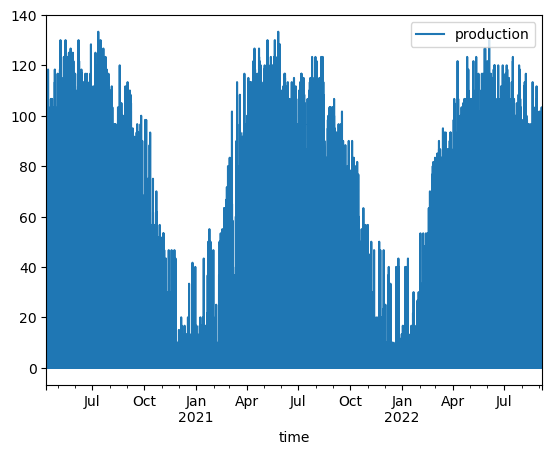

In [19]:
df_production_resampled.plot()

## Weer en zonnepanelen combineren

In [20]:
# Combineer de zonnepaneel en weerdata
# Interpoleer de ontbrekende waarden, zodat de weerdata ook per xx minuten beschikbaar is

df_merged = df_production_resampled.merge(df_weather_resampled, on='time', how='left')
df_merged['weer'] = df_merged['weer'].interpolate()
df_merged['production'] = df_merged['production'].interpolate()
print(df_merged)

                           production      weer
time                                           
2020-04-10 10:30:00+00:00   96.666667       NaN
2020-04-10 10:40:00+00:00   78.333333       NaN
2020-04-10 10:50:00+00:00   86.666667       NaN
2020-04-10 11:00:00+00:00   90.000000  7.316289
2020-04-10 11:10:00+00:00   86.666667  7.354273
...                               ...       ...
2022-09-06 16:50:00+00:00    6.666667  8.000000
2022-09-06 17:00:00+00:00    6.666667  8.000000
2022-09-06 17:10:00+00:00    3.333333  8.000000
2022-09-06 17:20:00+00:00    3.333333  8.000000
2022-09-06 17:30:00+00:00    3.333333  8.000000

[126619 rows x 2 columns]


## Filter op zonnige dagen

In [21]:
N = 0 # https://www.meteo.be/nl/info/weerwoorden/bewolkingsgraad
df_zonnig = df_merged.loc[df_merged['weer'] < 1]
print(df_zonnig)

                           production           weer
time                                                
2020-04-12 00:00:00+00:00    0.000000   7.715901e-01
2020-04-12 00:10:00+00:00    0.000000   7.190440e-01
2020-04-12 00:20:00+00:00    0.000000   6.664979e-01
2020-04-12 00:30:00+00:00    0.000000   6.139518e-01
2020-04-12 00:40:00+00:00    0.000000   5.614057e-01
...                               ...            ...
2022-09-03 17:00:00+00:00    6.666667  1.867937e-317
2022-09-03 17:10:00+00:00   10.000000   7.339437e-01
2022-09-03 22:00:00+00:00    0.000000   2.279036e-01
2022-09-03 22:10:00+00:00    0.000000   5.963170e-01
2022-09-03 22:20:00+00:00    0.000000   9.647304e-01

[15038 rows x 2 columns]


# Modeling

In [22]:
# Gegeven:
def model_zonnestraling(tilt:float, azimuth:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid stroom die een paneel maximaal produceert met 100% efficientie"""

    zonne_positie_aan_hemel = pvlib.solarposition.get_solarposition(tijdsreeks, lat, lon)

    #locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'Europe/Amsterdam'))
    locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'UTC'))
    heldere_hemel = locatie.get_clearsky(tijdsreeks)

    instraling = pvlib.irradiance.get_total_irradiance(tilt,
                                                       azimuth,
                                                       zonne_positie_aan_hemel['zenith'],
                                                       zonne_positie_aan_hemel['azimuth'],
                                                       heldere_hemel.dni,
                                                       heldere_hemel.ghi,
                                                       heldere_hemel.dhi)

    return instraling['poa_global'].to_frame().rename(columns={'poa_global':'zonlicht'})

In [23]:
# Aanvullen
def model_paneel(tilt:float, azimuth:float, efficientie:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid geabsorbeerd zonlicht op een paneel op basis van de efficientie"""

    zonnestraling = model_zonnestraling(tilt, azimuth, tijdsreeks, lat, lon)

    return zonnestraling * efficientie

In [24]:
# Aanvullen
def loss(params:Tuple[float,float,float], df_waarneming:pd.DataFrame, lat:float, lon:float) -> float:

    (tilt, azimuth, efficientie) = params

    tijdsreeks = df_waarneming.index

    df_model = model_paneel(tilt, azimuth, efficientie, tijdsreeks, lat, lon) # Aanvullen

    return ((df_model['zonlicht'] - df_waarneming['production'])**2).sum()


In [25]:
# Eerste inschatting
tilt = 35
azimuth = 180
efficientie = 0.2

In [26]:
# Zwolle, I guess? https://www.latlong.net/
lat = 52.512791
lon = 6.091540

result = minimize(loss, (tilt, azimuth, efficientie), (df_zonnig, lat, lon)) # Aanvullen
x = result['x']

## Evaluation

In [16]:
print("Tilt:        {0:.1f}°".format(x[0]))
print("Azimuth:     {0:.1f}°".format(x[1]))
print("Efficientie: {0:.1f}%".format(x[2]*100))

Tilt:        12.4°
Azimuth:     232.4°
Efficientie: 11.5%


<Axes: xlabel='time'>

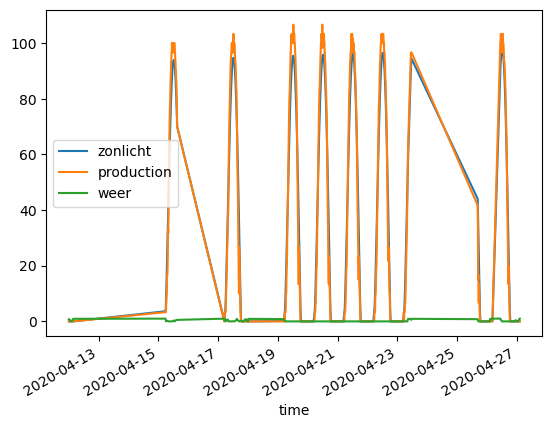

In [27]:
df_model = model_paneel(x[0], x[1], x[2], df_zonnig.index, lat, lon)
df_model['production'] = df_zonnig['production']
df_model['weer'] = df_zonnig['weer']

df_model = df_model.loc['2020-04-01':'2020-04-30']

df_model.plot()